# WeatherPy 
UCB Extension HW6
written by A. Lam

# Analysis
- Observation 1: As evidenced by the Temperature vs. Latitude scatterplot, temperature appears to behave roughly as a function of latitude, with a local maximum at latitude 0 (the equator).
- Observation 2: Cloudiness, Wind Speed and Humidity do not appear to be functions of latitude, as scatterplots of the three do not show any clear relationship  and appear mostly randomly scattered.
- Observation 3: Cloudiness, Wind Speed, and Humidity don't appear to bear any sort of direct relationship to longgitude either.

# Setup

In [1]:
# Modules
# Other modules are imported within the functions in which they are relevant
import pandas as pd
import matplotlib.pyplot as plt

# Generate Coordinates

In [2]:
def rand_coord():
    import random
    # Lat ranges from degrees [-90, 90] (N,S)
    lat = round(180*random.random()-90,2) 
    # Long ranges from degrees [-180, 180] (E,W)
    long = round(360*random.random()-180,2)
    return [lat,long]

# Convert Coordinates to City, Country

In [3]:
def coord2city(coords):
    # assume coords is a 2 item list of form: [lat,long]
    from citipy import citipy
    # extracts city name
    city = citipy.nearest_city(coords[0],coords[1]).city_name
    # extracts country code
    country = citipy.nearest_city(coords[0],coords[1]).country_code
    out = [city, country]
    return out

# API Call
API call is broken into three functions:
1. Call rand_coord and coord2city to generate an API call and touch endpoint
2. Check for a valid response, if not, run another API call
3. Output valid API call response to dataframe

In [4]:
def rand_city_API(debug = False):
    # Modules
    import requests as req
    import json
    import OpenWeatherMap_API as owm
    
    # generate city and log coords, name, and country
    coords = rand_coord()
    place = coord2city(coords)
    
    # Keep variables for output
    city = place[0]
    country_code = place[1]
    
    city_id_q = '?q=' + city + ',' + country_code
    # API query structure
    base_url = 'http://api.openweathermap.org/data/2.5/weather'
    api_key = '&appid=' + owm.avl
    units = '&units=imperial'
    # construct query URL
    clean_url = base_url+city_id_q+units+'&appid=InsertKey'
    url = base_url+city_id_q+units+api_key
    # make API call
    if debug:
        print('processing URL: ' + clean_url)
    response = req.get(url).json()
    
    #print(json.dumps(response,indent=2,sort_keys=True))
    
    return (response,clean_url)

In [5]:
def response2df(response, url='not provided'):
    import pandas as pd
    # assume input is a good API call to OpenWeatherMap API
    
    # output variables
    city = response['name']
    country_code = response['sys']['country']
    humidity = response['main']['humidity']
    temperature = response['main']['temp']
    cloudiness = response['clouds']['all']
    windspeed = response['wind']['speed']
    latitude = response['coord']['lat']
    longitude = response['coord']['lon']
        
    # Create dataframe of output variables
    output_order = ['City', 'Country Code', 'Latitude',
        'Longitude', 'Temperature', 'Humidity',
        'Cloudiness', 'Wind Speed', 'URL']
    out = pd.DataFrame({
        'City' : city,
        'Country Code' : country_code,
        'Latitude' : latitude,
        'Longitude' : longitude,
        'Temperature' : temperature,
        'Humidity' : humidity,
        'Cloudiness' : cloudiness,
        'Wind Speed' : windspeed,
        'URL' : url
    }, index = [0])
    
    return out[output_order]

In [6]:
def rand_city_data(debug = False):
    is_valid = False
    while is_valid == False:
        response, url = rand_city_API(debug = debug)
        if response['cod'] == 200:
            df = response2df(response, url = url)
            is_valid = True
        else:
            is_valid = False
    return df

In [7]:
# Generate Data Set
n_cities = 500 
data = rand_city_data() # initial df to append to
for i in range(n_cities - 1): # subtract 1 to accomodate for initial df
    data = data.append(rand_city_data(), ignore_index=True)

# Check if unique cities meets criteria
# if not, drop duplicate rows and replace with new data
while (data['City']+data['Country Code']).nunique() != n_cities:
    for i in range(n_cities - len((data['City']+data['Country Code']).unique())): 
        data = data.append(rand_city_data(), ignore_index=True)
    print('Generated ' + str(len((data['City']+data['Country Code']).unique())) + 
          ' unique cities out of ' + str(n_cities) + ' requested.')
    data.drop_duplicates(keep = 'first', inplace = True)

# Print Data Set to .csv
data.to_csv('weather_data_avl.csv', index = False)

Generated 350 unique cities out of 500 requested.
Generated 403 unique cities out of 500 requested.
Generated 439 unique cities out of 500 requested.
Generated 460 unique cities out of 500 requested.
Generated 470 unique cities out of 500 requested.
Generated 480 unique cities out of 500 requested.
Generated 488 unique cities out of 500 requested.
Generated 491 unique cities out of 500 requested.
Generated 493 unique cities out of 500 requested.
Generated 494 unique cities out of 500 requested.
Generated 496 unique cities out of 500 requested.
Generated 497 unique cities out of 500 requested.
Generated 497 unique cities out of 500 requested.
Generated 499 unique cities out of 500 requested.
Generated 499 unique cities out of 500 requested.
Generated 499 unique cities out of 500 requested.
Generated 499 unique cities out of 500 requested.
Generated 500 unique cities out of 500 requested.


In [8]:
data.head()

,City,Country Code,Latitude,Longitude,Temperature,Humidity,Cloudiness,Wind Speed,URL
0,Barrow,US,71.29,-156.79,3.20,84,90,27.51,http://api.openweathermap.org/data/2.5/weather...
1,Kota,IN,25.18,75.83,66.87,83,0,6.87,http://api.openweathermap.org/data/2.5/weather...
2,Husavik,IS,66.04,-17.34,26.60,79,0,4.70,http://api.openweathermap.org/data/2.5/weather...
3,Yining,CN,29.04,114.56,56.83,29,0,3.29,http://api.openweathermap.org/data/2.5/weather...
4,Qaanaaq,GL,77.48,-69.36,10.08,84,44,4.85,http://api.openweathermap.org/data/2.5/weather...


# Plot scatterplot of coordinates for coverage

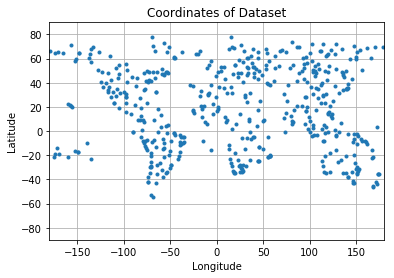

In [9]:
plt.plot(data['Longitude'],data['Latitude'],'.')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinates of Dataset')
plt.grid(True)
plt.show()

# Plot Temperature vs. Latitude

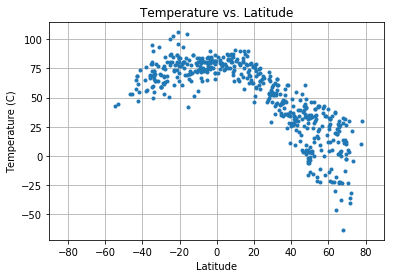

In [10]:
plt.plot(data['Latitude'],data['Temperature'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs. Latitude')
plt.grid(True)
plt.show()

# Plot Humidity vs. Latitude and Longitude

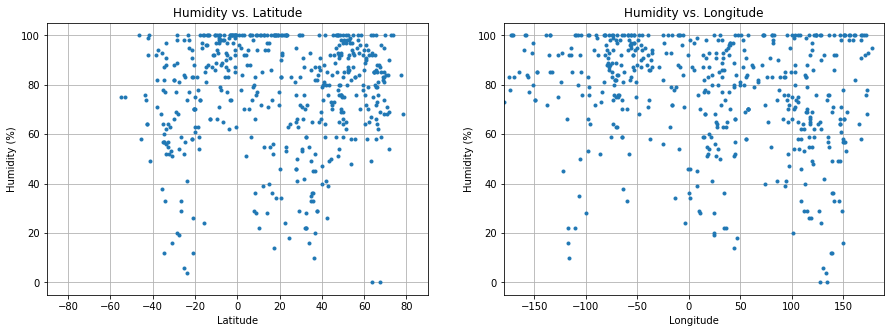

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(data['Latitude'],data['Humidity'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Humidity vs. Latitude')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data['Longitude'],data['Humidity'],'.')
plt.xlim([-180,190])
plt.xlabel('Longitude')
plt.ylabel('Humidity (%)')
plt.title('Humidity vs. Longitude')
plt.grid(True)
plt.show()

# Plot Cloudiness vs. Latitude

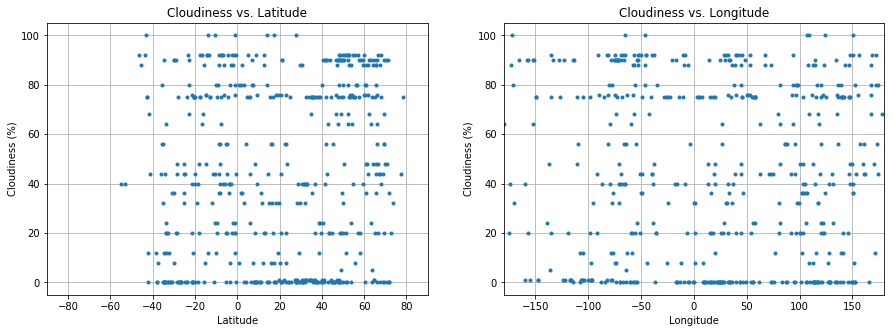

In [12]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(data['Latitude'],data['Cloudiness'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('Cloudiness vs. Latitude')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data['Longitude'],data['Cloudiness'],'.')
plt.xlim([-180,180])
plt.xlabel('Longitude')
plt.ylabel('Cloudiness (%)')
plt.title('Cloudiness vs. Longitude')
plt.grid(True)
plt.show()

# Plot Wind Speed vs. Latitude

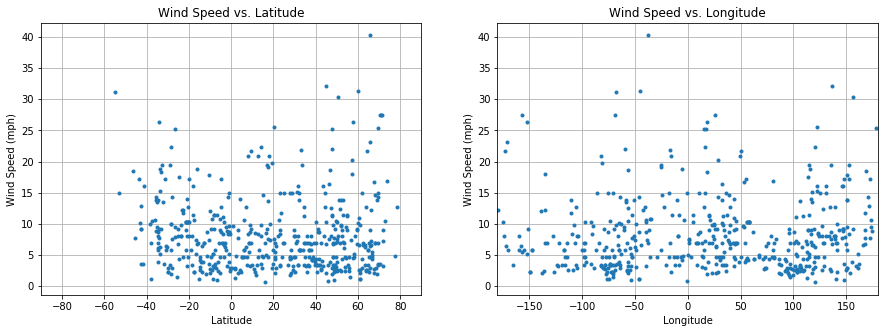

In [13]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(data['Latitude'],data['Wind Speed'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('Wind Speed vs. Latitude')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data['Longitude'],data['Wind Speed'],'.')
plt.xlim([-180,180])
plt.xlabel('Longitude')
plt.ylabel('Wind Speed (mph)')
plt.title('Wind Speed vs. Longitude')
plt.grid(True)
plt.show()